In [2]:
pip uninstall keras

Found existing installation: keras 2.8.0
Uninstalling keras-2.8.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/keras-2.8.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/keras/*
Proceed (y/n)? ERROR: Operation cancelled by user
^C


In [ ]:
pip uninstall tensorflow

In [ ]:
pip install -r requirements2.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 377.1 MB 9.3 kB/s 
     |████████████████████████████████| 336 kB 7.8 MB/s 
     |████████████████████████████████| 13.1 MB 46.9 MB/s 
     |████████████████████████████████| 10.4 MB 44.5 MB/s 
     |████████████████████████████████| 20.3 MB 93.6 MB/s 
     |████████████████████████████████| 3.1 MB 26.5 MB/s 
     |████████████████████████████████| 488 kB 73.9 MB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorbo

In [ ]:
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Input, Dense, Activation, Reshape,Flatten, Dropout, Lambda, RepeatVector, Concatenate
from keras.layers import Bidirectional, LSTM, CuDNNLSTM, GRU,CuDNNGRU, UpSampling2D
from keras.layers.merge import Add,Multiply
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Convolution1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam,Nadam,RMSprop
from keras.utils import plot_model
#from keras.utils.training_utils import multi_gpu_model
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime as dt
import os
from shutil import copyfile
import pandas as pd

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Generator, Discriminator Models

In [ ]:
def generator_model_RNN(seq_len, data_dim, module):
    if module == 'gru':
        Module = CuDNNGRU
    elif module == 'lstm':
        Module = CuDNNLSTM
    input_noise = Input(shape=(100, ))
    model = Sequential()
    model.add(Dense(2048, kernel_initializer='random_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Reshape((256,8)))
#     model.add(UpSampling2D())
    
    model.add(Bidirectional(Module(256, kernel_initializer='random_uniform', return_sequences=True, input_shape=(256,8))))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
#     model.add(UpSampling2D())

    model.add(Bidirectional(Module(256, kernel_initializer='random_uniform')))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(0.2))

    model.add(Dense((seq_len+2)*data_dim, kernel_initializer='random_uniform'))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((seq_len+2, data_dim)))
    model = model(input_noise)
                             
    model = Model(input_noise,model)
    return model



def discriminator_model_RNN(seq_len, data_dim,module):
    if module == 'gru':
        Module = CuDNNGRU
    elif module == 'lstm':
        Module = CuDNNLSTM
    num_layer = 2048
    model = Sequential()
    model.add(Bidirectional(Module(256, input_shape = (seq_len+2,data_dim), return_sequences=True)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.9))
    model.add(Bidirectional(Module(256, return_sequences=True)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.9))
    
    for i in range(int(np.log2(num_layer))):
        num_layer /=2
        num_layer = int(num_layer)
        model.add(Dense(num_layer))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.9))
        
    model.add(LeakyReLU(0.2))
    model.add(Reshape((1024,)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.9))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

def discriminator_model(seq_len, data_dim):
    model = Sequential()
    model.add(Convolution1D(64,10,border_mode='same',input_shape=(seq_len+2, data_dim)))
    model.add(LeakyReLU(0.2))
    model.add(Convolution1D(128,10,border_mode='same'))
    model.add(LeakyReLU(0.2))
    model.add(Convolution1D(128,10,border_mode='same'))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.8))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 10, input_shape=(130, 1), padding="same")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(128, 10, padding="same")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(128, 10, padding="same")`


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, batch: 0, g_loss: 0.476408, d_loss: -0.003286


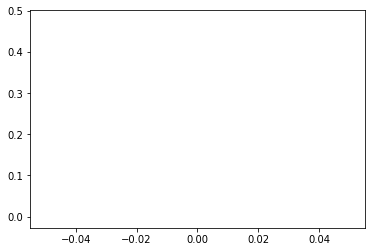

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 1, batch: 0, g_loss: 0.703391, d_loss: -0.268509


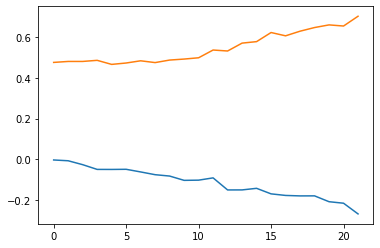

epoch: 2, batch: 0, g_loss: 0.809409, d_loss: -0.376487


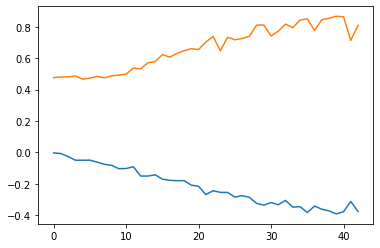

epoch: 3, batch: 0, g_loss: 0.747507, d_loss: -0.374942


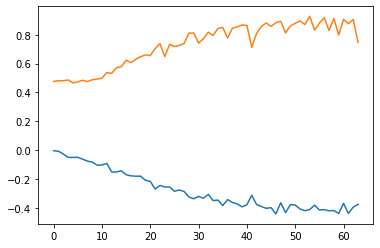

epoch: 4, batch: 0, g_loss: 0.775725, d_loss: -0.375258


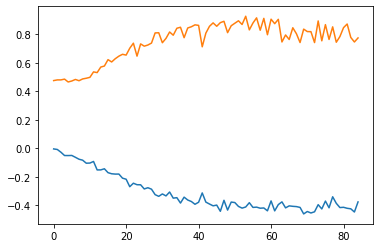

epoch: 5, batch: 0, g_loss: 0.708157, d_loss: -0.411240


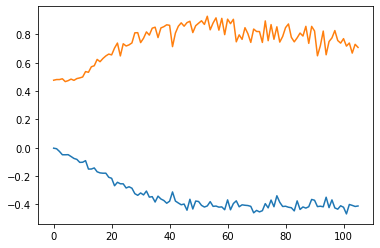

epoch: 6, batch: 0, g_loss: 0.725224, d_loss: -0.423511


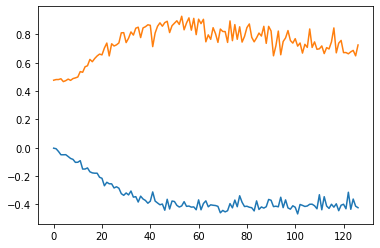

epoch: 7, batch: 0, g_loss: 0.568266, d_loss: -0.366826


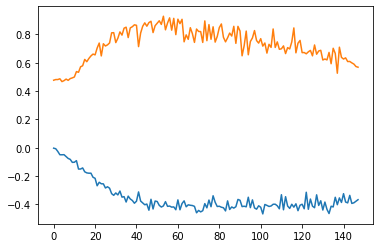

epoch: 8, batch: 0, g_loss: 0.608879, d_loss: -0.336223


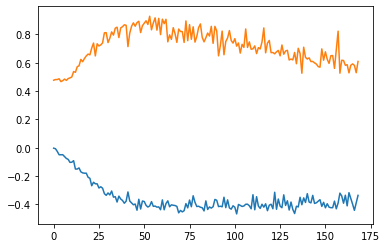

epoch: 9, batch: 0, g_loss: 0.469135, d_loss: -0.419796


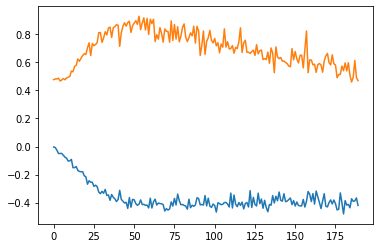

epoch: 10, batch: 0, g_loss: 0.599862, d_loss: -0.474173


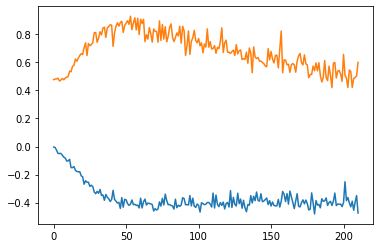

epoch: 11, batch: 0, g_loss: 0.514889, d_loss: -0.423802


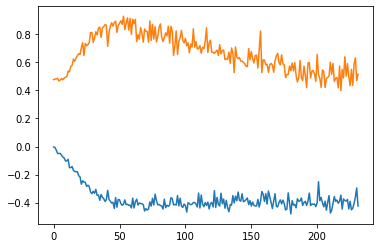

epoch: 12, batch: 0, g_loss: 0.559505, d_loss: -0.429721


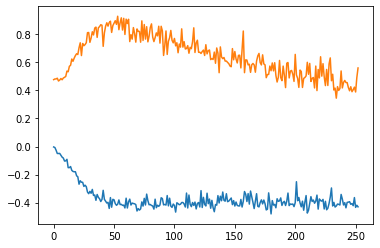

epoch: 13, batch: 0, g_loss: 0.348745, d_loss: -0.373731


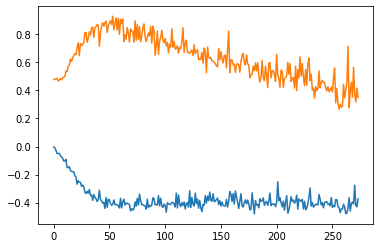

epoch: 14, batch: 0, g_loss: 0.330795, d_loss: -0.280950


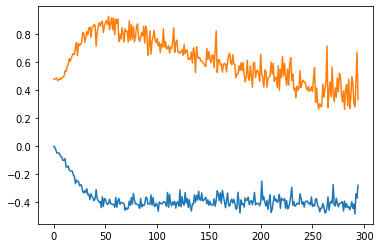

epoch: 15, batch: 0, g_loss: 0.440179, d_loss: -0.365920


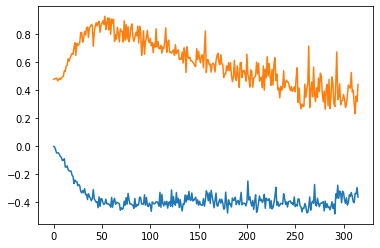

epoch: 16, batch: 0, g_loss: 0.444577, d_loss: -0.209504


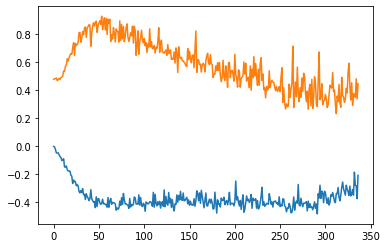

epoch: 17, batch: 0, g_loss: 0.981862, d_loss: -0.229925


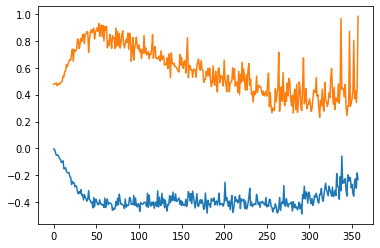

epoch: 18, batch: 0, g_loss: 0.368721, d_loss: -0.217082


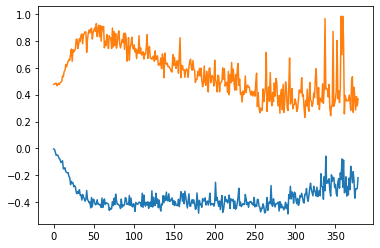

epoch: 19, batch: 0, g_loss: 0.694417, d_loss: -0.203804


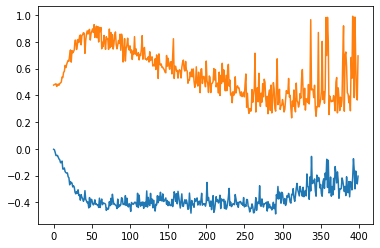

epoch: 20, batch: 0, g_loss: 0.335346, d_loss: -0.286957


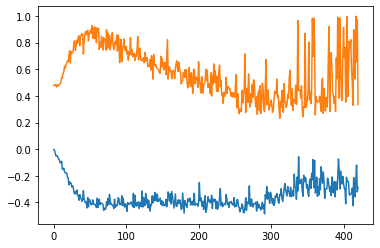

epoch: 21, batch: 0, g_loss: 0.414296, d_loss: -0.448724


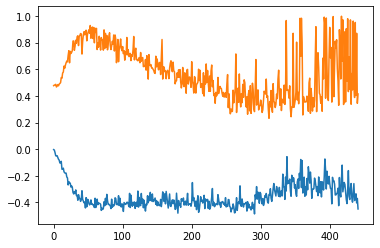

epoch: 22, batch: 0, g_loss: 0.389085, d_loss: -0.300094


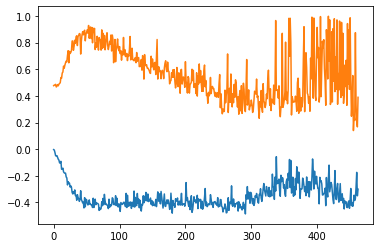

epoch: 23, batch: 0, g_loss: 0.951096, d_loss: -0.381965


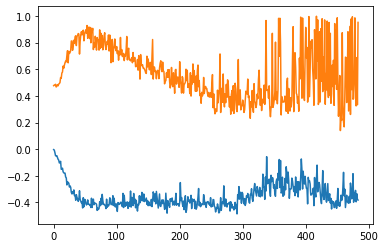

epoch: 24, batch: 0, g_loss: 0.391056, d_loss: -0.232163


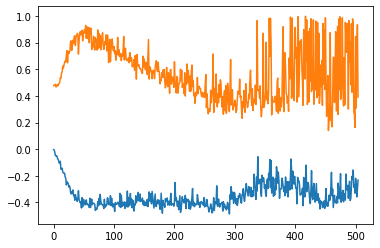

epoch: 25, batch: 0, g_loss: 0.239535, d_loss: -0.461271


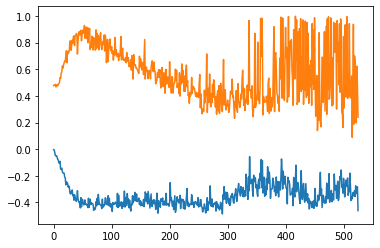

epoch: 26, batch: 0, g_loss: 0.175269, d_loss: -0.338986


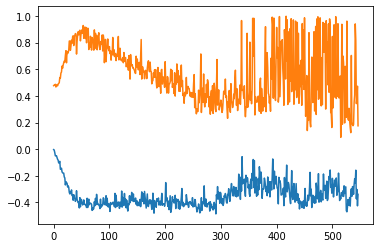

epoch: 27, batch: 0, g_loss: 0.205414, d_loss: -0.118736


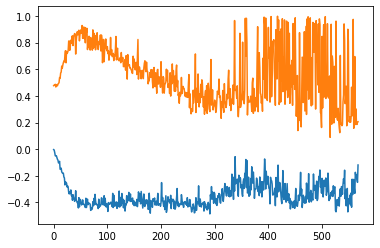

epoch: 28, batch: 0, g_loss: 0.179875, d_loss: -0.171322


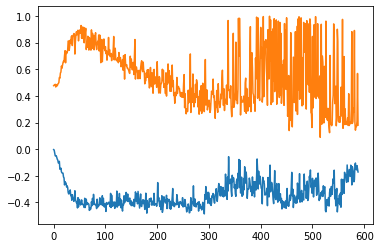

epoch: 29, batch: 0, g_loss: 0.210368, d_loss: -0.236336


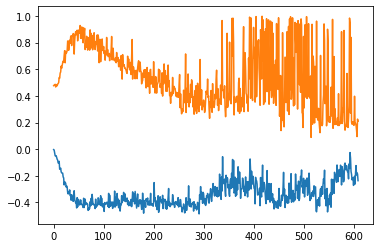

epoch: 30, batch: 0, g_loss: 0.209358, d_loss: -0.330575


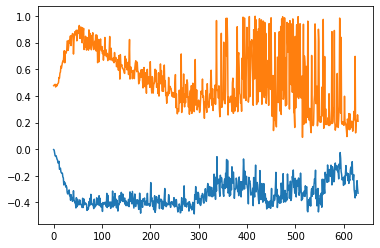

epoch: 31, batch: 0, g_loss: 0.239576, d_loss: -0.401151


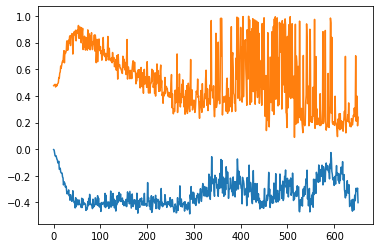

epoch: 32, batch: 0, g_loss: 0.301796, d_loss: -0.433943


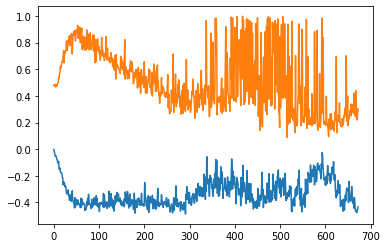

epoch: 33, batch: 0, g_loss: 0.219501, d_loss: -0.172861


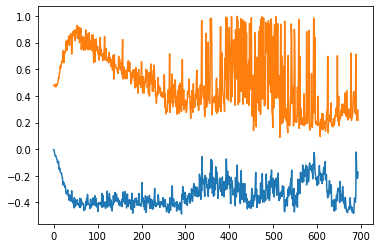

epoch: 34, batch: 0, g_loss: 0.166354, d_loss: -0.132358


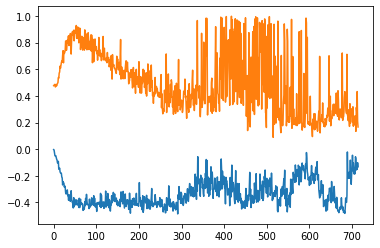

epoch: 35, batch: 0, g_loss: 0.250569, d_loss: -0.118176


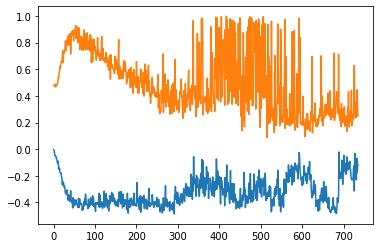

epoch: 36, batch: 0, g_loss: 0.134346, d_loss: -0.012476


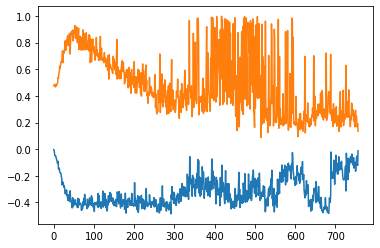

epoch: 37, batch: 0, g_loss: 0.137117, d_loss: -0.066662


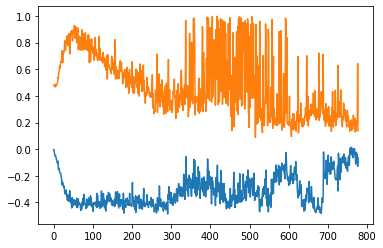

epoch: 38, batch: 0, g_loss: 0.263098, d_loss: -0.217697


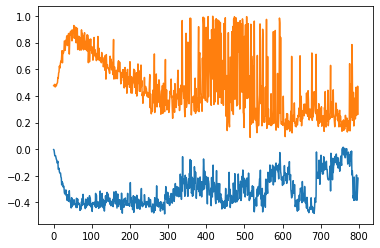

epoch: 39, batch: 0, g_loss: 0.133861, d_loss: 0.000250


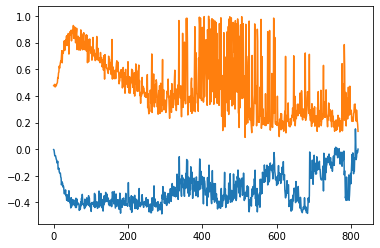

epoch: 40, batch: 0, g_loss: 0.127992, d_loss: -0.061697


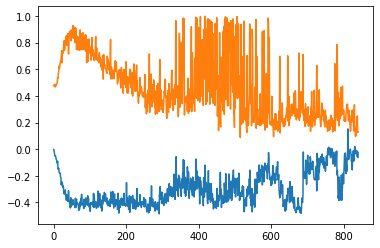

epoch: 41, batch: 0, g_loss: 0.250355, d_loss: -0.022911


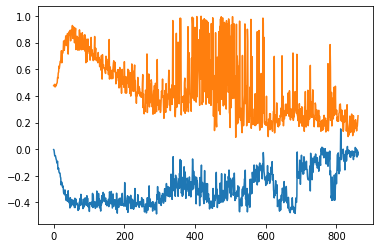

epoch: 42, batch: 0, g_loss: 0.277566, d_loss: -0.017335


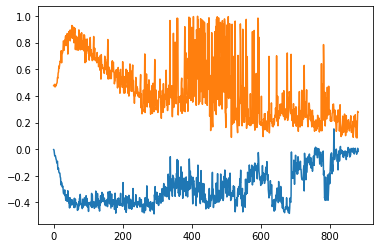

epoch: 43, batch: 0, g_loss: 0.206415, d_loss: -0.035285


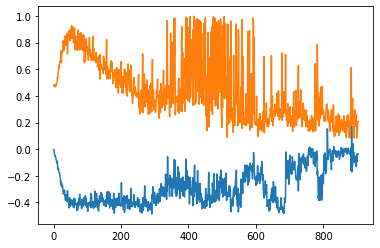

epoch: 44, batch: 0, g_loss: 0.209563, d_loss: -0.060158


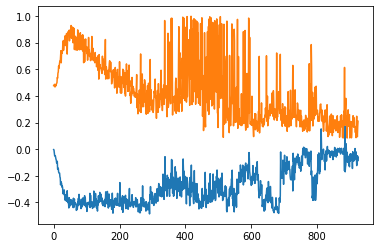

epoch: 45, batch: 0, g_loss: 0.250585, d_loss: -0.215482


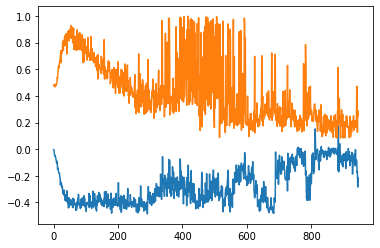

epoch: 46, batch: 0, g_loss: 0.252498, d_loss: -0.076934


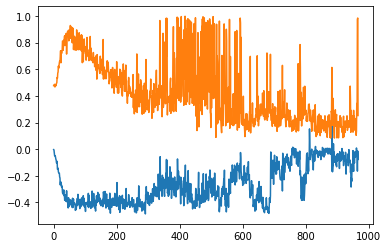

epoch: 47, batch: 0, g_loss: 0.215445, d_loss: -0.320933


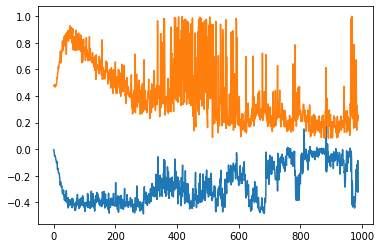

epoch: 48, batch: 0, g_loss: 0.107605, d_loss: -0.114273


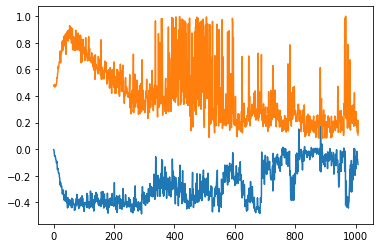

epoch: 49, batch: 0, g_loss: 0.208389, d_loss: -0.050959


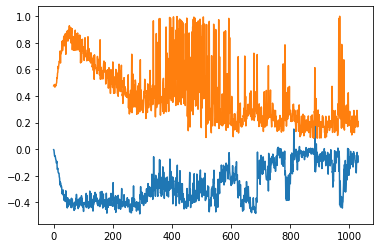

In [ ]:
# Data
seq_len = 128
AAPL = pd.read_csv('data/AAPL.csv')['Price']
AAPL = (AAPL-np.min(AAPL))/(np.max(AAPL)-np.min(AAPL))
AAPL = np.array(AAPL)
DG,dg = [], []

for i in range(len(AAPL)-seq_len+1):
  series = AAPL[i:i+seq_len]
  dg.append(series)
  m, M = np.min(series), np.max(series)
  series = (series - m)/(M-m)
  series = np.concatenate((series,np.array([m,M])))
  DG.append(series)


data_dim, z_dim = 1, 100


batch_size = 24
batches = int(len(AAPL)/batch_size)
epochs, interval = 50, 100

timestamp = dt.now().strftime("%Y%m%d_%H%M%S")
timestamp += '_'
timestamp += ''

discriminator_lr, generator_lr, generator_model = 5e-5, 5e-5, 'lstm' #or 'gru'

os.mkdir('./save/%s_%s'%(timestamp,generator_model))
os.mkdir('./save/%s_%s/npy'%(timestamp,generator_model))
os.mkdir('./save/%s_%s/imgs'%(timestamp,generator_model))

generator = generator_model_RNN(seq_len, data_dim, generator_model)
discriminator = discriminator_model(seq_len, data_dim)

def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)


d_opt = RMSprop(lr=discriminator_lr)
discriminator.compile(loss=wasserstein_loss, optimizer=d_opt)

discriminator.trainable = False
for e in discriminator.layers:
    e.trainable = False
gan = Sequential([generator,discriminator])
g_opt = RMSprop(lr=generator_lr)
gan.compile(loss=wasserstein_loss, optimizer=g_opt)


g_loss_recorder, d_loss_recorder = [], []

#start training

loss_diff = 1
for epoch in range(epochs):
    for index in range(batches):
        noise = np.array([np.random.normal(0,1.0,size = z_dim) for _ in range(batch_size)])
        random = np.random.choice(np.arange(len(dg)),batch_size)

        data = []
        for i in random:
          data.append(DG[i])

        data = np.array(data)
        data = np.reshape(data, (batch_size, seq_len+2, data_dim))
        real_series = data

        real_series = np.nan_to_num(real_series)
        generated_series = generator.predict(noise, verbose=0)
        

        X = np.concatenate((real_series, generated_series))
        y = np.concatenate([np.ones(batch_size),-np.ones(batch_size)])
        d_loss = discriminator.train_on_batch(X, y)
        d_loss_recorder.append(d_loss)
        # update generator
        y = np.array([1.]*batch_size,dtype=np.float32)
        g_loss = gan.train_on_batch(noise, y)
        g_loss_recorder.append(g_loss)
        loss_diff_ = abs(g_loss-d_loss)



        # We are trying to capture the time step where the difference between generator and discriminator loss is minimal.
        if loss_diff_<loss_diff:
          loss_diff = loss_diff_
          noise_ = np.array([np.random.normal(0,1.0,size=100) for _ in range(1000)])
          generated_series_ = generator.predict(noise_, verbose=0)
          np.save('./save/%s_%s/npy/generated_time_series_minimal_loss_diff.npy'%(timestamp,generator_model),generated_series_)


        if index % interval == 0:
          noise_ = np.array([np.random.normal(0,1.0,size=100) for _ in range(1000)])
          generated_series_ = generator.predict(noise_, verbose=0)
          print("epoch: %d, batch: %d, g_loss: %f, d_loss: %f" % (epoch, index, g_loss, d_loss))
          plt.plot(d_loss_recorder)
          plt.plot(g_loss_recorder)
          plt.savefig('save/%s_%s/imgs/gan_loss_%i_%i.png'%(timestamp,generator_model, epoch,index))
          np.save('./save/%s_%s/npy/generated_time_series_%i_%i.npy'%(timestamp,generator_model, epoch,index),generated_series_)
          plt.show()
